# Lab 6: Supervised Learning Multiclass Classification with Cross-Validation and GridSearchCV

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (
accuracy_score, precision_score, recall_score,
f1_score, classification_report, confusion_matrix,
roc_auc_score, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Exercise 1: Data Understanding and Preprocessing

### 1.	Load the dataset and print .shape, .info(), .describe().

In [2]:
df = pd.read_csv('datasets/dug_dataset.csv')
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [5]:
df.describe(include='object')

,Sex,BP,Cholesterol,Drug
count,200,200,200,200
unique,2,3,2,5
top,M,HIGH,HIGH,DrugY
freq,104,77,103,91


In [6]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

### 2. Perform encoding for categorical features

In [7]:
le_sex = LabelEncoder()
le_bp = LabelEncoder()
le_chol = LabelEncoder()
le_drug = LabelEncoder()

df['Sex'] = le_sex.fit_transform(df['Sex'])
df['BP'] = le_bp.fit_transform(df['BP'])
df['Cholesterol'] = le_chol.fit_transform(df['Cholesterol'])
df['Drug'] = le_drug.fit_transform(df['Drug'])

In [8]:
df['Drug'].value_counts()

Drug
0    91
4    54
1    23
3    16
2    16
Name: count, dtype: int64

### 3.	Normalize Na_to_K and Age if needed.

In [9]:
scaler = StandardScaler()
df[['Age','Na_to_K']] = scaler.fit_transform(df[['Age','Na_to_K']])
df[['Age', 'Na_to_K']]

,Age,Na_to_K
0,-1.291591,1.286522
1,0.162699,-0.415145
2,0.162699,-0.828558
3,-0.988614,-1.149963
4,1.011034,0.271794
...,...,...
195,0.708057,-0.626917
196,-1.715759,-0.565995
197,0.465676,-0.859089
198,-1.291591,-0.286500


### 4.	Check the distribution of the target classes.

In [10]:
df['Drug'].value_counts()

Drug
0    91
4    54
1    23
3    16
2    16
Name: count, dtype: int64

### 5.	Split data into training and testing sets (80:20).

In [11]:
X = df[['Age','Sex','BP','Cholesterol','Na_to_K']]
y = df['Drug']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((160, 5), (160,), (40, 5), (40,))

## Exercise 2: Model Training and Evaluation

Train the following classifiers to predict Drug:
1. Logistic Regression  
2. Decision Tree Classifier  
3. Random Forest Classifier  
4. Support Vector Machine (SVM)
5. K-Nearest Neighbors

For each model:
1. Train using the training data
2. Predict on the test data
3. Evaluate with:
    1. Confusion matrix
    2. Accuracy
    3. Precision, Recall, F1-Score (macro and weighted average)
4. Use classification report to summarize performance


In [13]:
models = {
    'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=10),
    'DecisionTree': DecisionTreeClassifier(random_state=10),
    'RandomForest': RandomForestClassifier(random_state=10),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(probability=True, random_state=10)
}

In [14]:
train_metrics = pd.DataFrame(columns=['model','y_true','y_predicted','y_proba','accuracy','precision_weighted','recall_weighted','f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc','confusion_matrix'])
test_metrics = train_metrics.copy()

In [15]:
def print_and_log_metrics(
    name, yt, yp, yproba, 
    df, train_or_test=" ", 
    print_cm=True, print_cr=True
):
    acc = accuracy_score(yt, yp)

    weighted_prec = precision_score(yt, yp, average='weighted')
    weighted_rec = recall_score(yt, yp, average='weighted')
    weighted_f1 = f1_score(yt, yp, average='weighted')

    macro_prec = precision_score(yt, yp, average='macro')
    macro_rec = recall_score(yt, yp, average='macro')
    macro_f1 = f1_score(yt, yp, average='macro')
    
    classes = np.unique(yt)
    
    # Binarize for multiclass ROC
    yt_bin = label_binarize(yt, classes=classes)
    auc_score = roc_auc_score(yt_bin, yproba, multi_class='ovo', average='weighted')
        
    # Classification report
    if print_cm:
        print(f"=== {name} {train_or_test}: Classification Report ===")
        print(classification_report(yt, yp))
    
    # Confusion matrix
    cm = confusion_matrix(yt, yp)
    if print_cr:
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{name} {train_or_test} - Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    
    metrics_df = pd.DataFrame([{
        'model': name,
        'y_true': yt,
        'y_predicted': yp,
        'y_proba': yproba,
        'accuracy': acc,
        'precision_weighted': weighted_prec,
        'recall_weighted': weighted_rec,
        'f1_weighted': weighted_f1,
        'precision_macro': macro_prec,
        'recall_macro': macro_rec,
        'f1_macro': macro_f1,
        'roc_auc': auc_score,
        'confusion_matrix': cm
    }])
    
    return pd.concat([df, metrics_df], ignore_index=True)


=== LogisticRegression Train: Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        73
           1       0.95      1.00      0.97        18
           2       0.92      0.92      0.92        13
           3       1.00      0.92      0.96        13
           4       0.95      0.98      0.97        43

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160



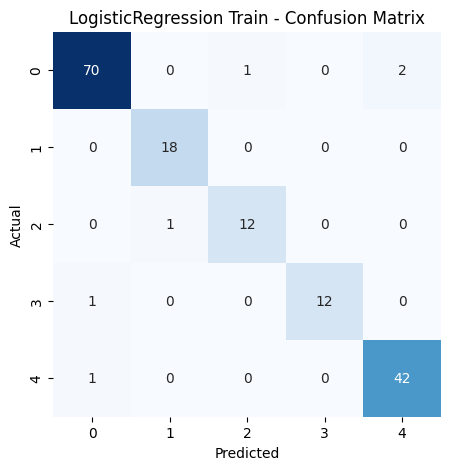

=== LogisticRegression Test: Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      0.67      0.80         3
           4       0.90      0.82      0.86        11

    accuracy                           0.90        40
   macro avg       0.95      0.89      0.91        40
weighted avg       0.90      0.90      0.90        40



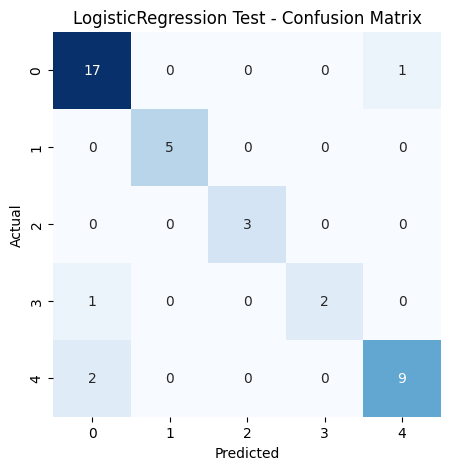

=== DecisionTree Train: Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        43

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



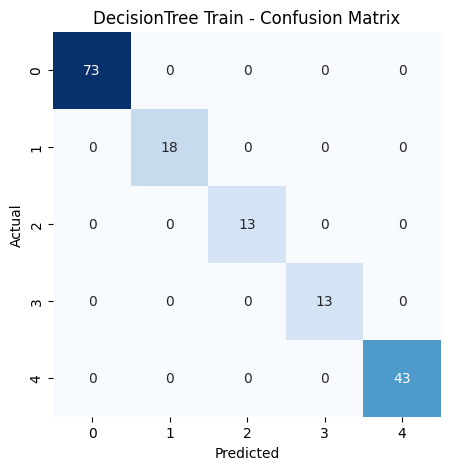

=== DecisionTree Test: Classification Report ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.91      0.95        11

    accuracy                           0.97        40
   macro avg       0.99      0.98      0.99        40
weighted avg       0.98      0.97      0.97        40



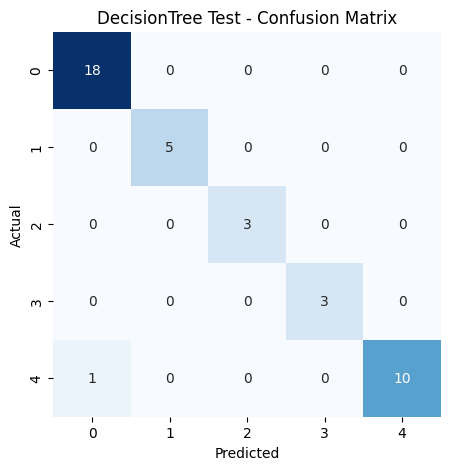

=== RandomForest Train: Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        43

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



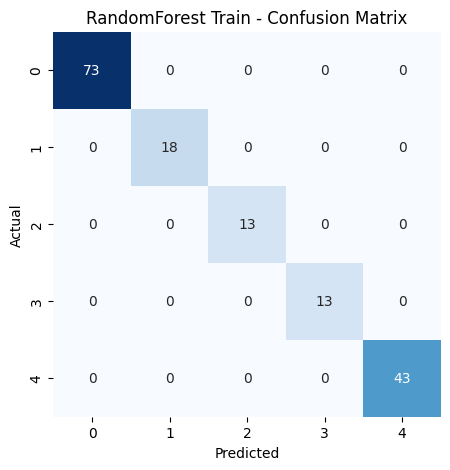

=== RandomForest Test: Classification Report ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.91      0.95        11

    accuracy                           0.97        40
   macro avg       0.99      0.98      0.99        40
weighted avg       0.98      0.97      0.97        40



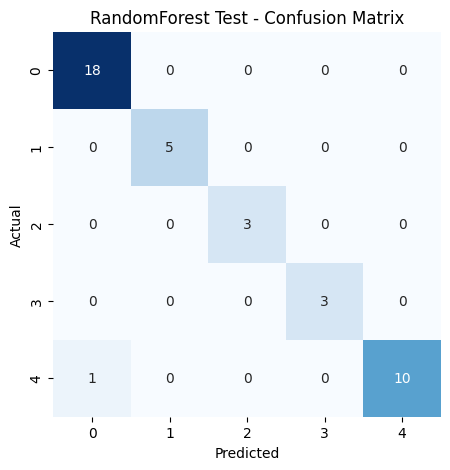

=== KNN Train: Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        73
           1       0.85      0.94      0.89        18
           2       0.85      0.85      0.85        13
           3       0.92      0.85      0.88        13
           4       0.95      0.98      0.97        43

    accuracy                           0.93       160
   macro avg       0.90      0.91      0.90       160
weighted avg       0.93      0.93      0.92       160



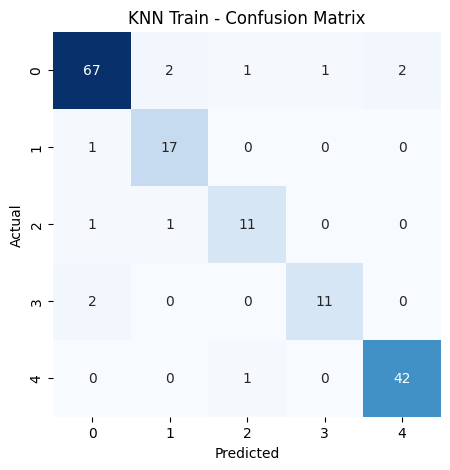

=== KNN Test: Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       1.00      0.80      0.89         5
           2       1.00      0.67      0.80         3
           3       1.00      0.33      0.50         3
           4       0.73      1.00      0.85        11

    accuracy                           0.82        40
   macro avg       0.91      0.73      0.77        40
weighted avg       0.85      0.82      0.82        40



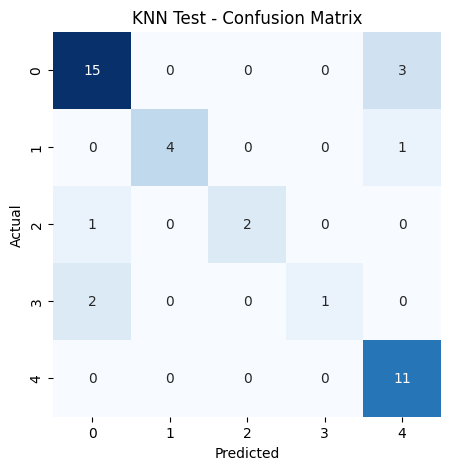

=== SVM Train: Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        73
           1       0.90      1.00      0.95        18
           2       0.92      0.92      0.92        13
           3       0.93      1.00      0.96        13
           4       1.00      0.98      0.99        43

    accuracy                           0.97       160
   macro avg       0.95      0.97      0.96       160
weighted avg       0.97      0.97      0.97       160



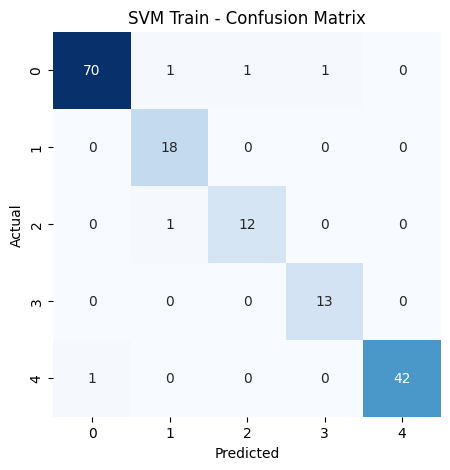

=== SVM Test: Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       0.92      1.00      0.96        11

    accuracy                           0.97        40
   macro avg       0.98      0.99      0.99        40
weighted avg       0.98      0.97      0.98        40



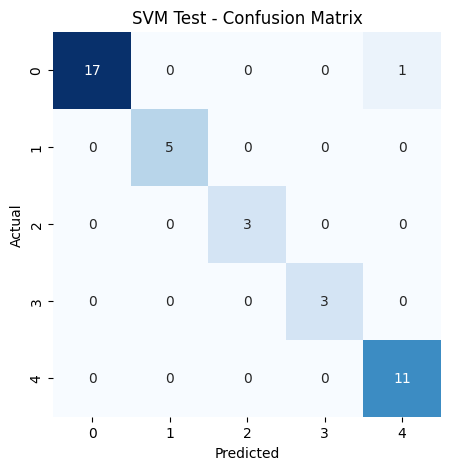

In [16]:
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilities (for ROC-AUC)
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)
        y_test_proba = model.predict_proba(X_test)
    else:
        # For SVC
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)
    
    # Log metrics
    train_metrics = print_and_log_metrics(name, y_train, y_train_pred, y_train_proba, train_metrics, train_or_test='Train')
    test_metrics = print_and_log_metrics(name, y_test, y_test_pred, y_test_proba, test_metrics, train_or_test='Test')


In [17]:
train_metrics[['model','accuracy','precision_weighted','recall_weighted','f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,LogisticRegression,0.96250,0.962939,0.96250,0.962459,0.959443,0.956360,0.957417,0.999202
1,DecisionTree,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
2,RandomForest,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
3,KNN,0.92500,0.925934,0.92500,0.924957,0.902206,0.906261,0.903393,0.992996
4,SVM,0.96875,0.970270,0.96875,0.968984,0.947513,0.971745,0.958773,0.999502


In [18]:
test_metrics[['model','accuracy','precision_weighted','recall_weighted','f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,LogisticRegression,0.900,0.905000,0.900,0.898346,0.950000,0.885859,0.910376,0.993329
1,DecisionTree,0.975,0.976316,0.975,0.974743,0.989474,0.981818,0.985071,0.977273
2,RandomForest,0.975,0.976316,0.975,0.974743,0.989474,0.981818,0.985071,1.000000
3,KNN,0.825,0.851667,0.825,0.816303,0.913333,0.726667,0.773675,0.955673
4,SVM,0.975,0.977083,0.975,0.975186,0.983333,0.988889,0.985590,1.000000


## Exercise 3: Cross-Validation and Hyperparameter Tuning

### 1.	Perform 5-fold cross-validation for Logistic Regression and Random Forest.

In [19]:
cv_train_metrics = pd.DataFrame(columns=train_metrics.columns)
cv_val_metrics = pd.DataFrame(columns=train_metrics.columns)
cv_test_metrics = pd.DataFrame(columns=test_metrics.columns)

In [20]:
cv_models = {
    'LogisticRegression': LogisticRegression(random_state=10),
    'RandomForest': RandomForestClassifier(random_state=42)
}

In [21]:
folds = 5
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=10)
for name, model in cv_models.items():
    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model.fit(X_tr, y_tr)
        
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)
        
        y_tr_proba = model.predict_proba(X_tr)
        y_val_proba = model.predict_proba(X_val)
        
        cv_train_metrics = print_and_log_metrics(name, y_tr, y_tr_pred, y_tr_proba, cv_train_metrics, train_or_test='Train', print_cm=False, print_cr=False)
        cv_val_metrics = print_and_log_metrics(name, y_val, y_val_pred, y_val_proba, cv_val_metrics, train_or_test='Validation', print_cm=False, print_cr=False)

    y_test_pred = model.predict(X_test)
         
    y_test_proba = model.predict_proba(X_test)
    
    cv_test_metrics = print_and_log_metrics(name, y_test, y_test_pred, y_test_proba, cv_test_metrics, train_or_test='Test', print_cm=False, print_cr=False)

In [22]:
cv_train_metrics.groupby('model')[['accuracy','precision_weighted','recall_weighted','f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']].mean()

,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
model,,,,,,,,
LogisticRegression,0.970313,0.971126,0.970313,0.970131,0.965737,0.954208,0.958753,0.999321
RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
cv_val_metrics.groupby('model')[['accuracy','precision_weighted','recall_weighted','f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']].mean()

,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
model,,,,,,,,
LogisticRegression,0.93750,0.950009,0.93750,0.936951,0.936043,0.921841,0.916792,0.996090
RandomForest,0.99375,0.995000,0.99375,0.993472,0.992000,0.986667,0.987556,0.999777


In [24]:
cv_test_metrics[['model','accuracy','precision_weighted','recall_weighted','f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,LogisticRegression,0.9,0.905,0.9,0.898346,0.95,0.885859,0.910376,0.993878
1,RandomForest,1.0,1.000,1.0,1.000000,1.00,1.000000,1.000000,1.000000


### 2.	Use cross_val_score to compute average accuracy, F1, and precision.

In [25]:
scoring = ['accuracy','recall_macro', 'f1_macro', 'precision_macro', 'recall_weighted', 'f1_weighted', 'precision_weighted']

cv_results = pd.DataFrame()

for name, model in models.items():    
    scores = {}
    for metric in scoring:
        cv_score = cross_val_score(model, X_train, y_train, cv=2, scoring=metric, n_jobs=4)
        scores[metric] = cv_score.mean()
    
    cv_results = pd.concat([
        cv_results,
        pd.DataFrame([{
            'model': name,
            'accuracy': scores['accuracy'],
            'f1_macro': scores['f1_macro'],
            'recall_macro': scores['recall_macro'],
            'precision_macro': scores['precision_macro'],
            'f1_weighted': scores['f1_weighted'],
            'recall_weighted': scores['recall_weighted'],
            'precision_weighted': scores['precision_weighted']
        }])
    ], ignore_index=True)

In [26]:
cv_results

,model,accuracy,f1_macro,recall_macro,precision_macro,f1_weighted,recall_weighted,precision_weighted
0,LogisticRegression,0.90000,0.842789,0.845613,0.915818,0.886640,0.90000,0.909540
1,DecisionTree,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
2,RandomForest,0.99375,0.987045,0.985714,0.990000,0.993674,0.99375,0.994375
3,KNN,0.86875,0.817933,0.833309,0.824248,0.864006,0.86875,0.869655
4,SVM,0.88750,0.851805,0.837968,0.906530,0.885164,0.88750,0.902795


### 3.	Apply GridSearchCV on Random Forest and SVM:
1. For Random Forest tune: n_estimators, max_depth
2. For SVM tune: C, kernel

In [27]:
param_grids = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=10),
        'params': {
            'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
            'max_depth': [None, 1, 2, 5, 10, 20, 50, 100]
        }
    },
    'SVC': {
        'model': SVC(probability=True, random_state=10),
        'params': {
            'C': [0.001, 0.01, 1, 2, 5, 10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    }
}

best_models = {}
best_params = {}

In [28]:
gcv_train_metrics = pd.DataFrame(columns=train_metrics.columns)
gcv_test_metrics = pd.DataFrame(columns=test_metrics.columns)

===== GridSearchCV for RandomForest =====
Fitting 2 folds for each of 80 candidates, totalling 160 fits
RandomForest best params: {'max_depth': None, 'n_estimators': 1}
RandomForest best CV score: nan
=== Best_RandomForest Train: Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        73
           1       0.94      0.89      0.91        18
           2       1.00      1.00      1.00        13
           3       0.73      0.85      0.79        13
           4       0.95      0.91      0.93        43

    accuracy                           0.94       160
   macro avg       0.92      0.93      0.92       160
weighted avg       0.95      0.94      0.94       160



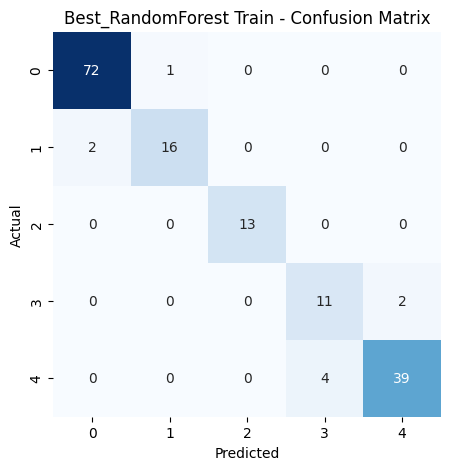

=== Best_RandomForest Test: Classification Report ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         3
           3       0.50      0.67      0.57         3
           4       0.89      0.73      0.80        11

    accuracy                           0.88        40
   macro avg       0.86      0.84      0.84        40
weighted avg       0.89      0.88      0.88        40



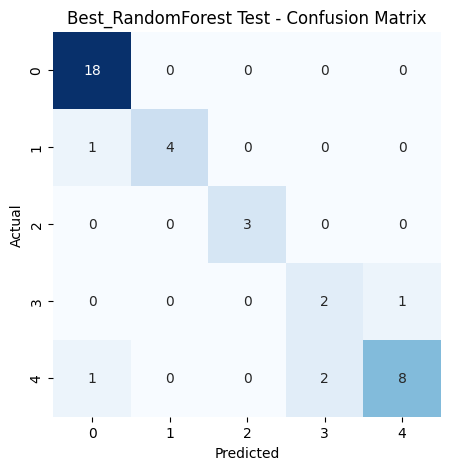

===== GridSearchCV for SVC =====
Fitting 2 folds for each of 24 candidates, totalling 48 fits
SVC best params: {'C': 0.001, 'kernel': 'linear'}
SVC best CV score: nan
=== Best_SVC Train: Classification Report ===
              precision    recall  f1-score   support

           0       0.46      1.00      0.63        73
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        43

    accuracy                           0.46       160
   macro avg       0.09      0.20      0.13       160
weighted avg       0.21      0.46      0.29       160



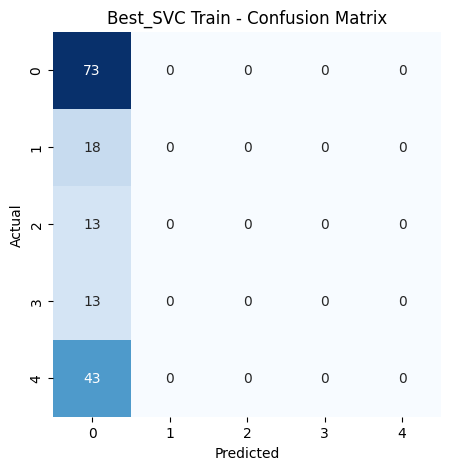

=== Best_SVC Test: Classification Report ===
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        18
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        11

    accuracy                           0.45        40
   macro avg       0.09      0.20      0.12        40
weighted avg       0.20      0.45      0.28        40



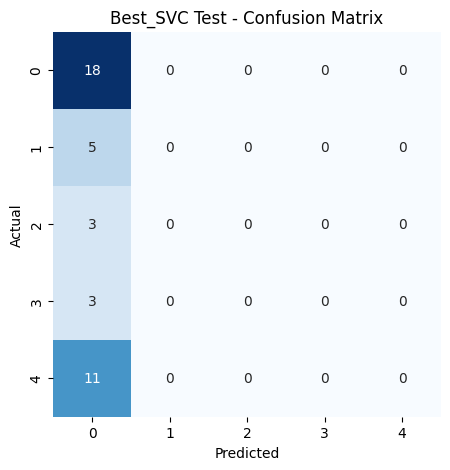

In [29]:
for name, mp in param_grids.items():
    print(f"===== GridSearchCV for {name} =====")
    
    grid = GridSearchCV(mp['model'], mp['params'], verbose=1, cv=2, scoring='f1', n_jobs=4)
    
    grid.fit(X_train, y_train)
    
    print(f"{name} best params: {grid.best_params_}")
    print(f"{name} best CV score: {grid.best_score_:.4f}")
    
    best_models[name] = grid.best_estimator_
    best_params[name] = grid.best_params_

    y_test_pred = best_models[name].predict(X_test)
    y_train_pred = best_models[name].predict(X_train)
    y_test_proba = best_models[name].predict_proba(X_test)
    y_train_proba = best_models[name].predict_proba(X_train)
    
    gcv_train_metrics = print_and_log_metrics(
        f"Best_{name}", y_train, y_train_pred, y_train_proba, gcv_train_metrics, train_or_test="Train"
    )
    gcv_test_metrics = print_and_log_metrics(
        f"Best_{name}", y_test, y_test_pred, y_test_proba, gcv_test_metrics, train_or_test="Test"
    )


In [30]:
best_models, best_params

({'RandomForest': RandomForestClassifier(n_estimators=1, random_state=10),
  'SVC': SVC(C=0.001, kernel='linear', probability=True, random_state=10)},
 {'RandomForest': {'max_depth': None, 'n_estimators': 1},
  'SVC': {'C': 0.001, 'kernel': 'linear'}})

In [31]:
gcv_train_metrics[['model','accuracy','precision_weighted','recall_weighted',
'f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,Best_RandomForest,0.94375,0.946275,0.94375,0.944439,0.91974,0.925664,0.921633,0.962832
1,Best_SVC,0.45625,0.208164,0.45625,0.285891,0.09125,0.200000,0.125322,0.989400


In [32]:
gcv_test_metrics[['model','accuracy','precision_weighted','recall_weighted',
'f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,Best_RandomForest,0.875,0.886944,0.875,0.875284,0.857778,0.838788,0.841537,0.910277
1,Best_SVC,0.450,0.202500,0.450,0.279310,0.090000,0.200000,0.124138,0.969074


## Exercise 4: Model Comparison Table

### 1. No Cross Validation model metrics

In [33]:
train_metrics[['model','accuracy','precision_weighted','recall_weighted',
'f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,LogisticRegression,0.96250,0.962939,0.96250,0.962459,0.959443,0.956360,0.957417,0.999202
1,DecisionTree,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
2,RandomForest,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
3,KNN,0.92500,0.925934,0.92500,0.924957,0.902206,0.906261,0.903393,0.992996
4,SVM,0.96875,0.970270,0.96875,0.968984,0.947513,0.971745,0.958773,0.999502


In [34]:
test_metrics[['model','accuracy','precision_weighted','recall_weighted',
'f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,LogisticRegression,0.900,0.905000,0.900,0.898346,0.950000,0.885859,0.910376,0.993329
1,DecisionTree,0.975,0.976316,0.975,0.974743,0.989474,0.981818,0.985071,0.977273
2,RandomForest,0.975,0.976316,0.975,0.974743,0.989474,0.981818,0.985071,1.000000
3,KNN,0.825,0.851667,0.825,0.816303,0.913333,0.726667,0.773675,0.955673
4,SVM,0.975,0.977083,0.975,0.975186,0.983333,0.988889,0.985590,1.000000


### 2. Cross Validation model metrics

In [35]:
cv_train_metrics.groupby('model')[['accuracy','precision_weighted','recall_weighted',
'f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']].mean()

,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
model,,,,,,,,
LogisticRegression,0.970313,0.971126,0.970313,0.970131,0.965737,0.954208,0.958753,0.999321
RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
cv_val_metrics.groupby('model')[['accuracy','precision_weighted','recall_weighted',
'f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']].mean()

,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
model,,,,,,,,
LogisticRegression,0.93750,0.950009,0.93750,0.936951,0.936043,0.921841,0.916792,0.996090
RandomForest,0.99375,0.995000,0.99375,0.993472,0.992000,0.986667,0.987556,0.999777


In [37]:
cv_test_metrics[['model','accuracy','precision_weighted','recall_weighted',
'f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,LogisticRegression,0.9,0.905,0.9,0.898346,0.95,0.885859,0.910376,0.993878
1,RandomForest,1.0,1.000,1.0,1.000000,1.00,1.000000,1.000000,1.000000


In [38]:
cv_results

,model,accuracy,f1_macro,recall_macro,precision_macro,f1_weighted,recall_weighted,precision_weighted
0,LogisticRegression,0.90000,0.842789,0.845613,0.915818,0.886640,0.90000,0.909540
1,DecisionTree,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
2,RandomForest,0.99375,0.987045,0.985714,0.990000,0.993674,0.99375,0.994375
3,KNN,0.86875,0.817933,0.833309,0.824248,0.864006,0.86875,0.869655
4,SVM,0.88750,0.851805,0.837968,0.906530,0.885164,0.88750,0.902795


### 3. Best models metrics from Grid Search CV  

In [39]:
gcv_train_metrics[['model','accuracy','precision_weighted','recall_weighted',
'f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,Best_RandomForest,0.94375,0.946275,0.94375,0.944439,0.91974,0.925664,0.921633,0.962832
1,Best_SVC,0.45625,0.208164,0.45625,0.285891,0.09125,0.200000,0.125322,0.989400


In [40]:
gcv_test_metrics[['model','accuracy','precision_weighted','recall_weighted',
'f1_weighted','precision_macro','recall_macro','f1_macro','roc_auc']]

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,roc_auc
0,Best_RandomForest,0.875,0.886944,0.875,0.875284,0.857778,0.838788,0.841537,0.910277
1,Best_SVC,0.450,0.202500,0.450,0.279310,0.090000,0.200000,0.124138,0.969074


## Knowledge Check Questions

1.	What are the challenges in multiclass classification compared to binary classification?

More classes -> more complexity. model needs to separate multiple decision boundaries.  
Metrics become trickier: accuracy alone is misleading, need macro/micro/weighted averages.  
Class imbalance is worse: some classes may dominate, others barely show up.  
Computationally heavier: training time and memory usage increase with number of classes.  
Error interpretation is harder: misclassifying class A as class B isn’t equal in cost across all pairs.  

2.	Why is macro average preferred over micro average in imbalanced multiclass tasks?

Micro average aggregates over all instances → dominated by majority classes.  
Macro average treats each class equally → good for imbalanced datasets, since minority classes still influence the metric.  
Example: If 90% of data is one class, micro average will look “great” even if the model fails completely on minority classes.  

3.	How does cross-validation help in model selection?

Reduces variance from a single train/test split. Gives a more robust estimate of performance across folds. Prevents overfitting to one split -> helps pick models that generalize better. Useful for hyperparameter tuning.

4.	What is the purpose of GridSearchCV?

Automates hyperparameter tuning by exhaustively searching combinations. Uses cross-validation to evaluate each combination -> ensures fair comparison. Returns the best parameters and best model without manual trial-and-error.

5.	Why might KNN perform poorly in high-dimensional data?

distances between points become less meaningful, all points look “equidistant.” Model relies on distance → neighbors stop being reliable indicators. Needs exponentially more data to maintain performance as dimensions grow. Computation cost (distance calculation for all points) also explodes.